In [1]:
# !pip install -U -qq gdown kaggle

# from google.colab import drive
# drive.mount('/content/drive')

# import os
# !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/all_AI_code/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [2]:
import sys
sys.path.insert(1, "../")
import kaggle_api

In [2]:
# !kaggle competitions download -c fruit-ripening

100%|██████████████████████████████████████| 2.18G/2.18G [05:15<00:00, 5.98MB/s]
100%|██████████████████████████████████████| 2.18G/2.18G [05:15<00:00, 7.43MB/s]


In [3]:
import zipfile
import os
import os
from glob import glob

In [4]:
# with zipfile.ZipFile("./fruit-ripening.zip", "r") as zip_ref:
#     print("Unzipping main_zip data...") 
#     zip_ref.extractall('./data/')

# os.remove("./fruit-ripening.zip")

Unzipping main_zip data...


In [4]:
import random
from pathlib import Path
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [5]:
ls = glob('./data/train/train/*/*.png')

In [26]:
df_submit = pd.read_csv('./data/submission.csv')
df_submit['path'] = './data/test/test/' + df_submit['FileName']
df_submit.head()

,FileName,Class,path
0,abdy9380.png,0.0,./data/test/test/abdy9380.png
1,adua0170.png,0.0,./data/test/test/adua0170.png
2,aebq0222.png,5.0,./data/test/test/aebq0222.png
3,aeew6117.png,NaN,./data/test/test/aeew6117.png
4,aegl6733.png,NaN,./data/test/test/aegl6733.png


In [7]:
df_data = pd.DataFrame(ls,columns = ['path'])
df_data['label'] = df_data['path'].map(lambda x:int(x.split('/')[-2]))
df_data.sample(5)

,path,label
915,./data/train/train/0/IMG_20220426_220001.png,0
2121,./data/train/train/6/IMG_20220426_223556.png,6
2625,./data/train/train/2/IMG_20220426_165014.png,2
1693,./data/train/train/0/IMG_20220426_171339.png,0
1274,./data/train/train/0/IMG_20220427_155050.png,0


<Axes: >

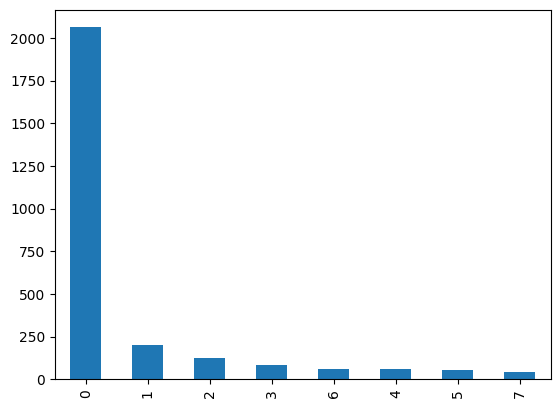

In [8]:
df_data['label'].value_counts().plot.bar()

In [9]:
import cv2

In [12]:
img = cv2.imread(df_data['path'][0])
img.shape

(600, 800, 3)

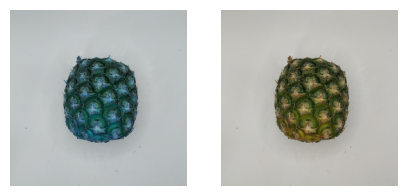

In [22]:
#BGR=>RGB
ls = list(df_data[df_data['label']==1].sample(5)['path'])
img = cv2.imread(ls[2])[100:500,200:600]
destRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (5,3))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(destRGB)
plt.axis('off')
plt.show()

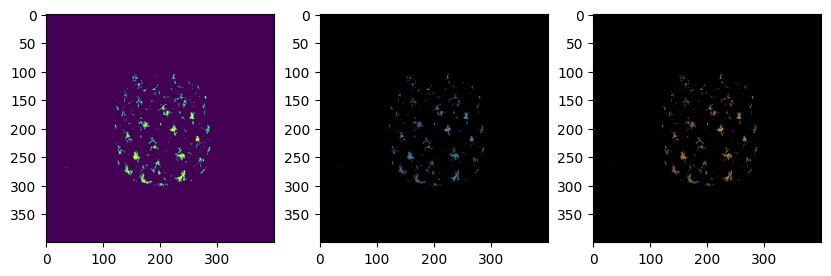

In [24]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask1 = cv2.inRange(hsv, (0, 100, 100), (20, 255,255))
mask2 = cv2.inRange(hsv, (170,100,100), (180, 255, 255))
mask = cv2.bitwise_or(mask1, mask2)
target = cv2.bitwise_and(img,img, mask=mask)
plt.figure(figsize = (10,3))
plt.subplot(1, 3, 1)
plt.imshow(mask)
plt.subplot(1, 3, 2)
plt.imshow(target)
plt.subplot(1, 3, 3)
destRGB = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
plt.imshow(destRGB)
plt.show()

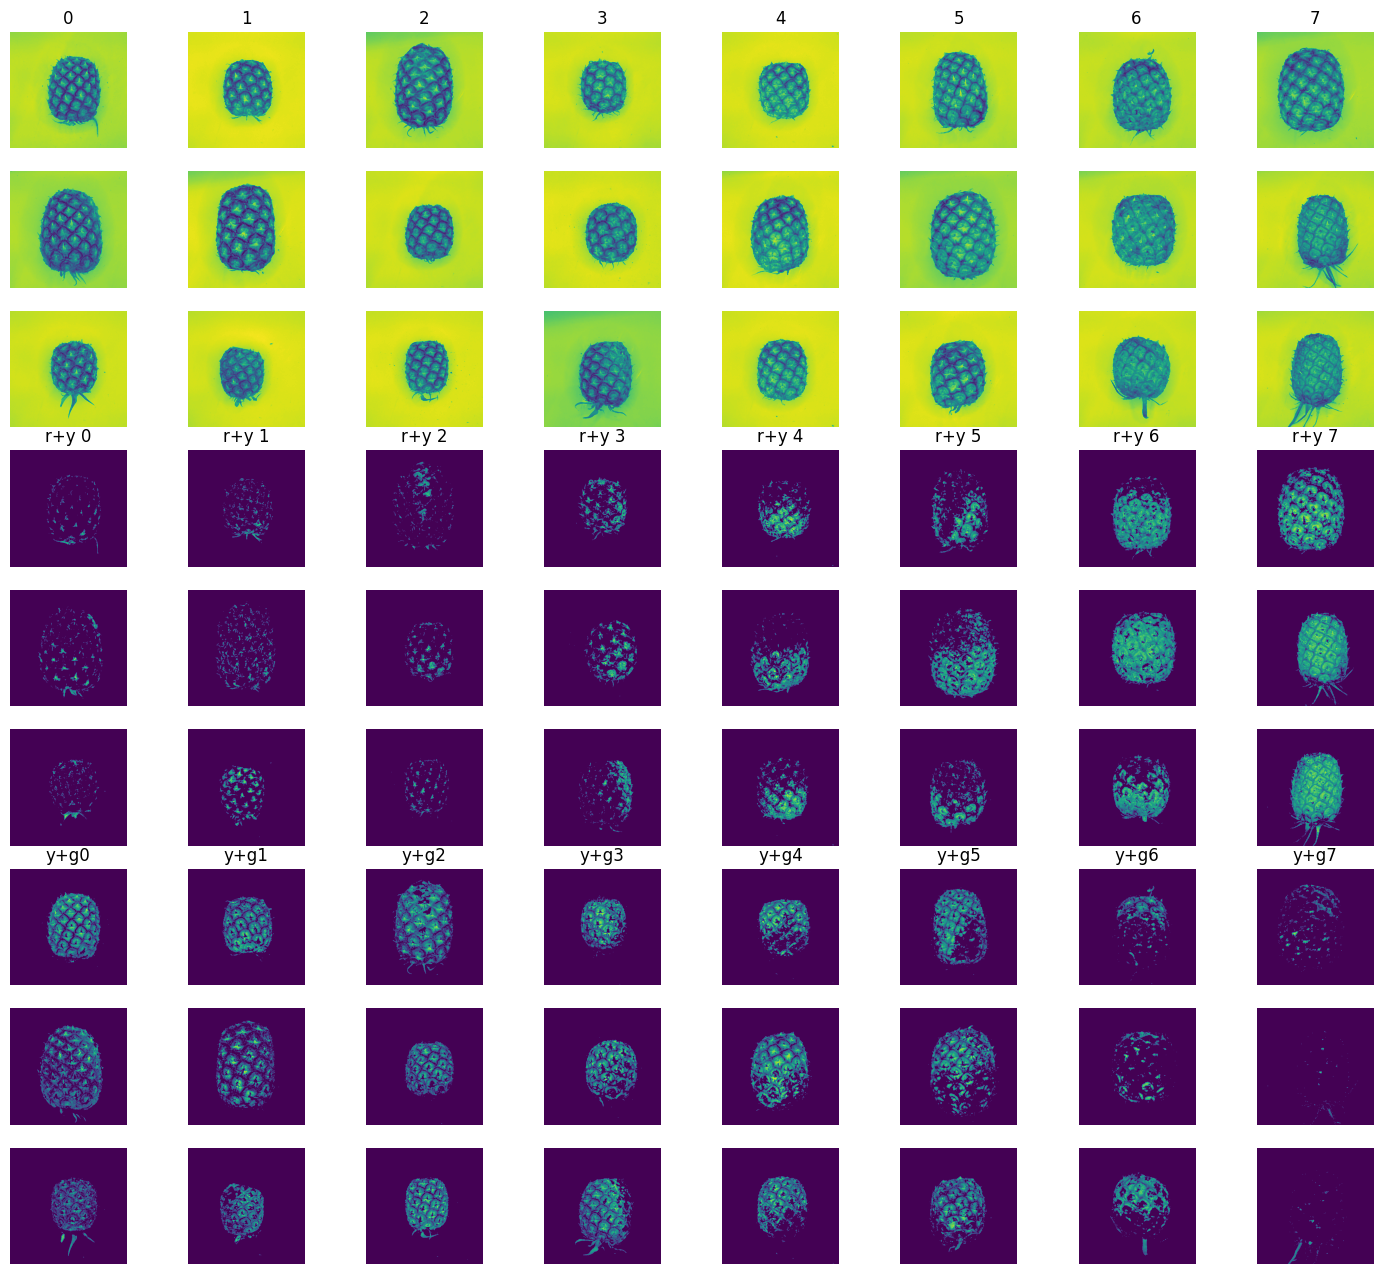

In [25]:
fig,axe = plt.subplots(9,8, figsize=(18, 16))
for i in range(8):
    ls = list(df_data[df_data['label']==i].sample(5)['path'])
    for j in range(3):
        img = cv2.imread(ls[j])[100:500,200:600]
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        ax = axe[j,i]
#         destRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if j==0:ax.set_title(i)
        ax.imshow(img_gray)
        ax.axis('off')

        ax = axe[j+3,i]
        if j==0:ax.set_title('r+y '+str(i))
        mask1 = cv2.inRange(hsv, (0, 100, 100), (20, 255,255))
        mask2 = cv2.inRange(hsv, (170,100,100), (180, 255, 255))
        mask = cv2.bitwise_or(mask1, mask2)
        target = cv2.bitwise_and(img,img, mask=mask)
#         destRGB = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
        gray_ry = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
        ax.imshow(gray_ry)
        ax.axis('off')
        
        ax = axe[j+6,i]
        if j==0:ax.set_title('y+g'+str(i))
        mask = cv2.inRange(hsv, (21, 50, 50), (75, 255,255))
        target = cv2.bitwise_and(img,img, mask=mask)
#         destRGB = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
        gray_yg = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
        ax.imshow(gray_yg)
        ax.axis('off')

In [59]:
def preproc(img_path):
    img_rgb = cv2.imread(img_path)
    # img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2Lab)
    img = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    mask = np.zeros(img.shape, dtype=np.uint8)
    _,th = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    dl_img = cv2.dilate(th, kernel=np.ones((5, 5), np.uint8), iterations=1)
    dl_img[:,:150] = 0 
    dl_img[:,650:] = 0 
    dl_img = cv2.erode(dl_img, kernel=np.ones((3, 3), np.uint8), iterations=1)
    contours, hierarchy = cv2.findContours(dl_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    max_c = max(contours, key = cv2.contourArea)
    mask = cv2.fillPoly(mask, pts=[max_c], color=255)
    final = cv2.bitwise_and(img_rgb, img_rgb, mask = mask)
    destRGB = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)
    return destRGB[100:500,200:600]

<function matplotlib.pyplot.show(close=None, block=None)>

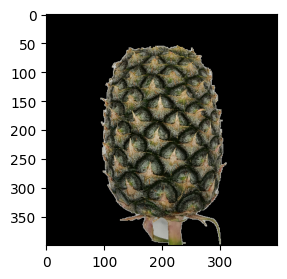

In [60]:
pth = df_data['path'].sample().item()
mask_img = preproc(pth)
plt.figure(figsize = (5,3))
plt.imshow(mask_img)
plt.show

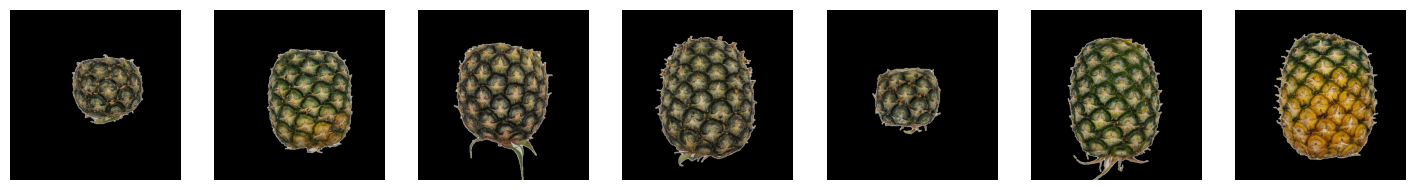

In [62]:
fig,axe = plt.subplots(1,7,figsize=(18, 8))
ls = list(df_data.sample(7)['path'])
for i in range(7):
    mask_img = preproc(ls[i])
    axe[i].imshow(mask_img)
    axe[i].axis('off')
plt.show()

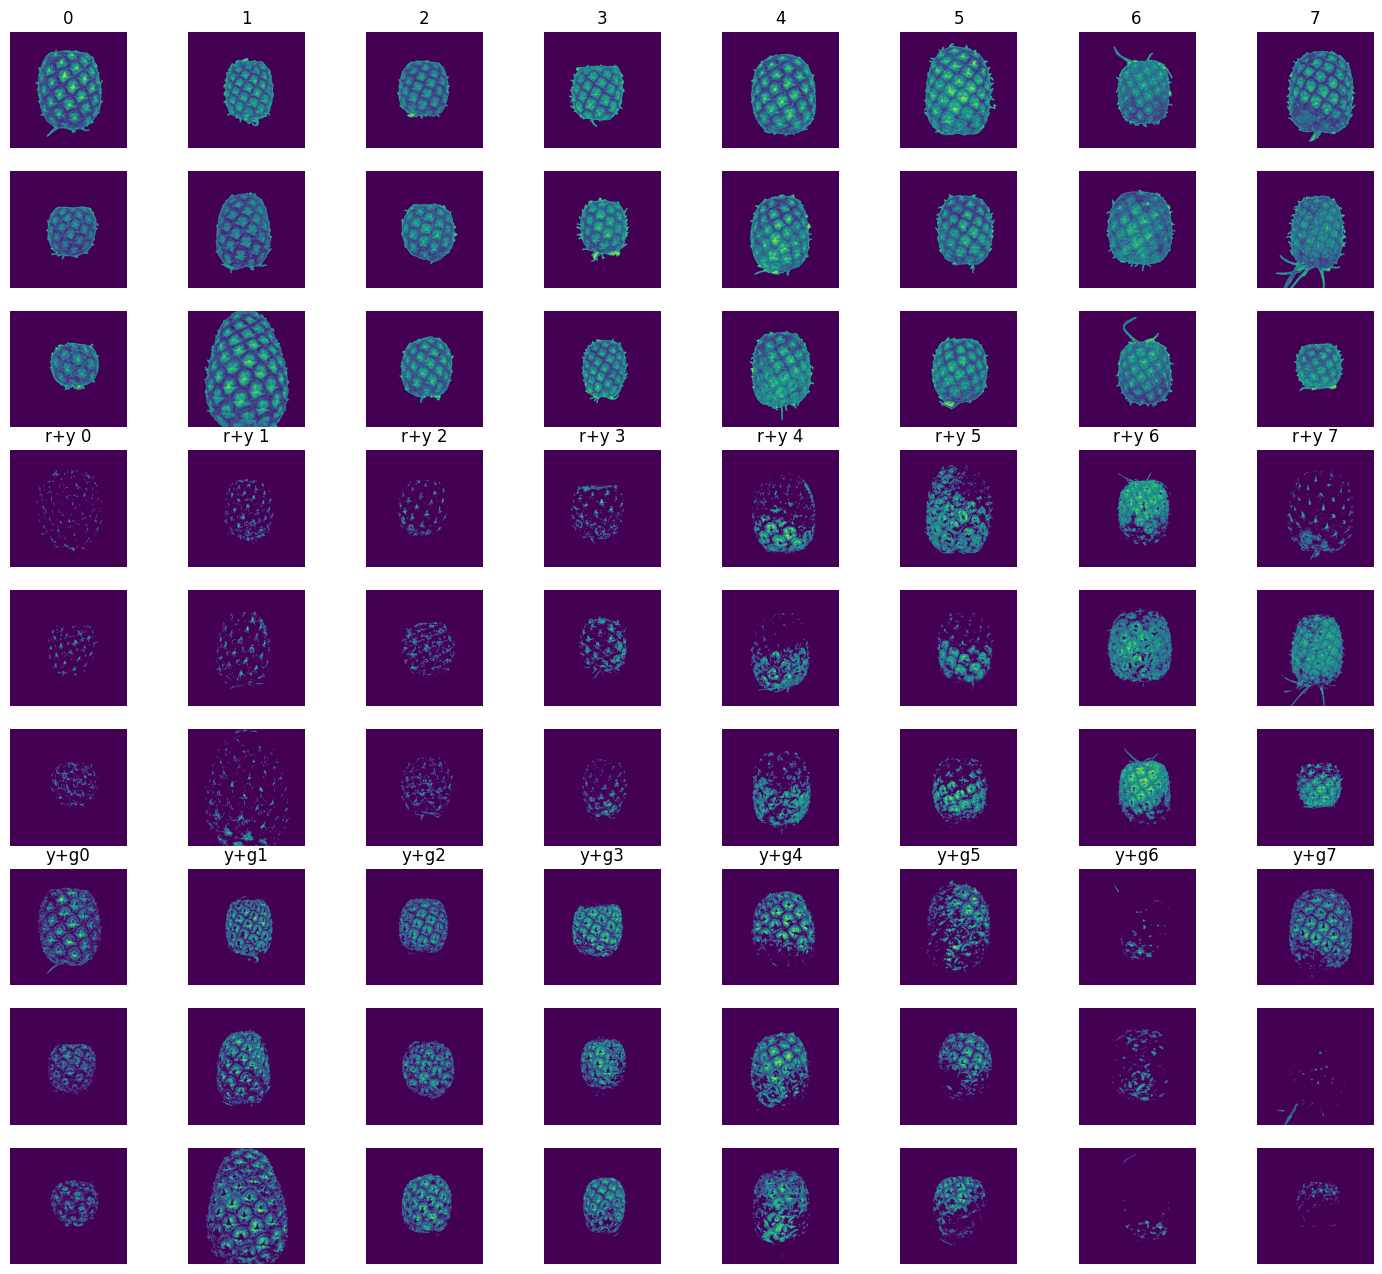

In [64]:
fig,axe = plt.subplots(9,8, figsize=(18, 16))
for i in range(8):
    ls = list(df_data[df_data['label']==i].sample(5)['path'])
    for j in range(3):
        img = preproc(ls[j])
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        ax = axe[j,i]
#         destRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if j==0:ax.set_title(i)
        ax.imshow(img_gray)
        ax.axis('off')

        ax = axe[j+3,i]
        if j==0:ax.set_title('r+y '+str(i))
        mask1 = cv2.inRange(hsv, (0, 100, 100), (20, 255,255))
        mask2 = cv2.inRange(hsv, (170,100,100), (180, 255, 255))
        mask = cv2.bitwise_or(mask1, mask2)
        target = cv2.bitwise_and(img,img, mask=mask)
#         destRGB = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
        gray_ry = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
        ax.imshow(gray_ry)
        ax.axis('off')
        
        ax = axe[j+6,i]
        if j==0:ax.set_title('y+g'+str(i))
        mask = cv2.inRange(hsv, (21, 50, 50), (75, 255,255))
        target = cv2.bitwise_and(img,img, mask=mask)
#         destRGB = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
        gray_yg = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
        ax.imshow(gray_yg)
        ax.axis('off')

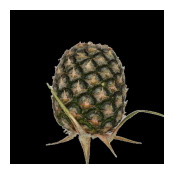

In [93]:
pth = df_data['path'].sample().item()
img = cv2.imread(pth)
plt.figure(figsize=(3,2))
mask_img = preproc(pth)
plt.imshow(mask_img)
plt.axis('off')
plt.show()

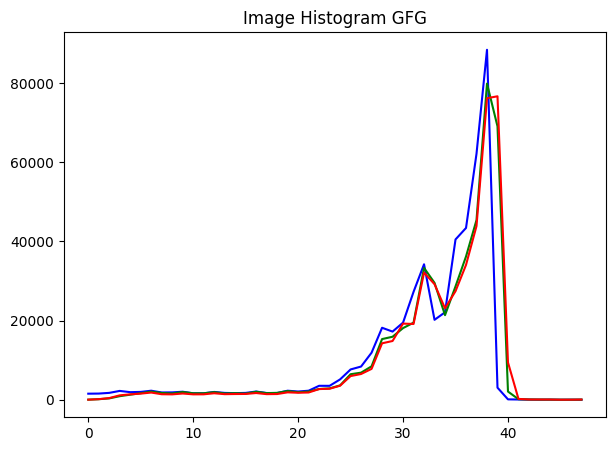

In [94]:
colors = ('b','g','r')
plt.figure(figsize=(7,5))
for i,color in enumerate(colors):
    hist = cv2.calcHist([img],[i],None,[48],[1,256])
    plt.plot(hist,color = color)
plt.title('Image Histogram GFG')
plt.show()

In [70]:
def calculate_histogram(image, color_space):
    if color_space == "hsv":
        converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_space == "hsl":
        converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    elif color_space == "ycbcr":
        converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    elif color_space == "rgb":
        converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif color_space == "lab":
        converted_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    else:
        raise ValueError("Unsupported color space")
    
    histograms = []
    for channel in cv2.split(converted_image):
        histogram = cv2.calcHist([channel], [0], None, [48], [1, 256])
        histogram = histogram.flatten()
        histograms.extend(histogram)
    return histograms

In [95]:
from PIL.ImageEnhance import Color, Contrast, Brightness, Sharpness
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance

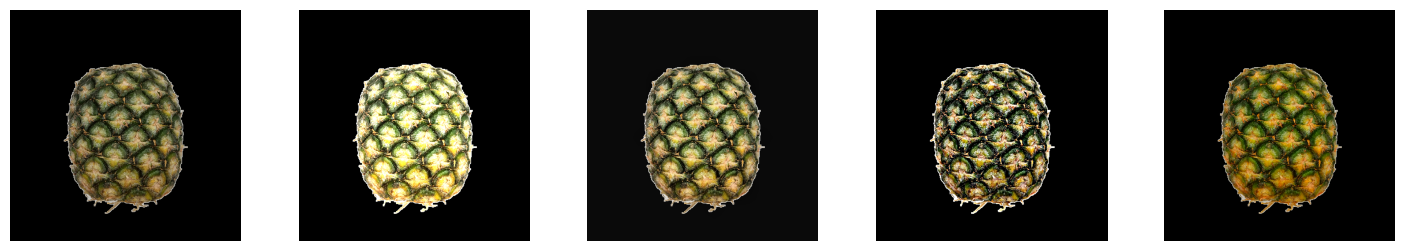

In [126]:
fig,axe = plt.subplots(1,5,figsize=(18, 3))
pth = df_data.sample(1)['path'].item()
image = preproc(pth)
pil_image = Image.fromarray(image)

axe[0].imshow(image)
axe[0].axis('off')

#Brightness
bright_img = Brightness(pil_image).enhance(2)
axe[1].imshow(np.array(bright_img))
axe[1].axis('off')

#Clahe
hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
h, s, v = hsv_img[:,:,0], hsv_img[:,:,1], hsv_img[:,:,2]
clahe = cv2.createCLAHE(clipLimit = 9.0, tileGridSize = (10,10))
v = clahe.apply(v)
hsv_img = np.dstack((h,s,v))
clahe_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
axe[2].imshow(clahe_img)
axe[2].axis('off')

#Unsharp Masking
usm_image = pil_image.filter(ImageFilter.UnsharpMask(radius = 5, percent = 150, threshold = 5))
axe[3].imshow(np.array(usm_image))
axe[3].axis('off')

#Color Enhancement
enhan_image = ImageEnhance.Color(pil_image).enhance(2.0)
axe[4].imshow(np.array(enhan_image))
axe[4].axis('off')
plt.show()